# Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

Create a Jupyter Notebook file called climate_analysis.ipynb and use it to complete your climate analysis and data exporation.
Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.
Use SQLAlchemy create_engine to connect to your sqlite database.
Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.

Precipitation Analysis

Design a query to retrieve the last 12 months of precipitation data.
Select only the date and prcp values.
Load the query results into a Pandas DataFrame and set the index to the date column.
Plot the results using the DataFrame plot method.

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base #convert python classes into SQL tables
from sqlalchemy.ext.automap import automap_base #convert python classes into SQL tables
from sqlalchemy import Column, Integer, String, Float, text
import pymysql
from sqlalchemy.orm import Session
pymysql.install_as_MySQLdb()
from sqlalchemy import func
from sqlalchemy import distinct
import matplotlib.pyplot as plt
import numpy as np

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
session=Session(bind=engine)

In [4]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
#Making sure tables for measurements and stations are in.
Base.classes.keys()

['measurements', 'stations']

In [10]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [11]:
first_row = session.query(Measurements).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1102f8a58>,
 'tobs': 65,
 'date': datetime.date(2010, 1, 1),
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 0}

In [12]:
first_row = session.query(Stations).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x110318630>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 0,
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [13]:
### Precipitation Analysis

#* Design a query to retrieve the last 12 months of precipitation data.
#* Select only the `date` and `prcp` values.

p12m = session.query(Measurements).filter(Measurements.date>='2016-08-23').with_entities(Measurements.date, Measurements.prcp)

#* Load the query results into a Pandas DataFrame and set the index to the date column.
df = pd.read_sql(p12m.statement, p12m.session.bind).set_index('date').reset_index().reset_index()

df.head()

,index,date,prcp
0,0,2016-08-23,0.00
1,1,2016-08-24,0.08
2,2,2016-08-25,0.08
3,3,2016-08-26,0.00
4,4,2016-08-27,0.00


In [14]:
#take average precipitation values for each date

prcp_by_date=pd.DataFrame(df.groupby(df['date'])['prcp'].mean()).reset_index()

prcp_by_date.head()

,date,prcp
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


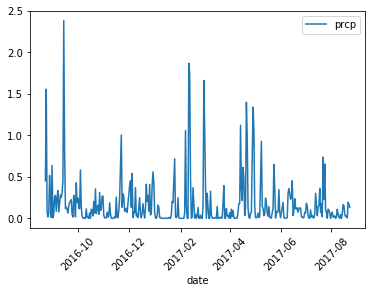

In [15]:
# Plot the results using the DataFrame `plot` method.

prcp_by_date.plot(kind='line',x='date',y='prcp')

plt.xticks(rotation=45)

plt.show()

In [16]:
#* Use Pandas to print the summary statistics for the precipitation data.

print("PRECIPITATION STATS: \n------------")
print(f"Mean: {round(np.mean(df['prcp']),2)}")
print(f"Median: {round(np.median(df['prcp']),2)}")
print(f"Min: {round(np.min(df['prcp']),2)}")
print(f"Max: {round(np.max(df['prcp']),2)}")
print(f"Standard Deviation: {round(np.std(df['prcp']),2)}")


PRECIPITATION STATS: 
------------
Mean: 0.18
Median: 0.02
Min: 0.0
Max: 6.7
Standard Deviation: 0.46


In [17]:
#STATION ANALYSIS

# Design a query to calculate the total number of stations.

total_stations = session.query(Measurements.station).distinct().count()
print(f"Total stations: {total_stations}")

# Design a query to find the most active stations.

result = session.query(Measurements.station, func.count(Measurements.prcp)).group_by(Measurements.station).order_by(func.count(Measurements.prcp).desc()).all()

# List the stations and observation counts in descending order

print('\nObservation counts by station:\n')

for row in result:
    print(f"{row[0]}: {row[1]}")


# Which station has the highest number of observations?
#  USC00519281

Total stations: 9

Observation counts by station:

USC00519281: 2772
USC00513117: 2696
USC00519397: 2685
USC00519523: 2572
USC00516128: 2484
USC00514830: 1937
USC00511918: 1932
USC00517948: 683
USC00518838: 342


In [20]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.

p12m_temp = session.query(Measurements).filter(Measurements.date>='2016-08-01',Measurements.date<'2017-08-01',Measurements.station=='USC00519281').with_entities(Measurements.date, Measurements.tobs)
df = pd.read_sql(p12m_temp.statement, p12m_temp.session.bind).set_index('date').reset_index().reset_index()
df.head()

,index,date,tobs
0,0,2016-08-01,76
1,1,2016-08-02,76
2,2,2016-08-03,77
3,3,2016-08-04,77
4,4,2016-08-05,81


In [21]:
df.tail()

,index,date,tobs
360,360,2017-07-27,76
361,361,2017-07-28,81
362,362,2017-07-29,82
363,363,2017-07-30,81
364,364,2017-07-31,76


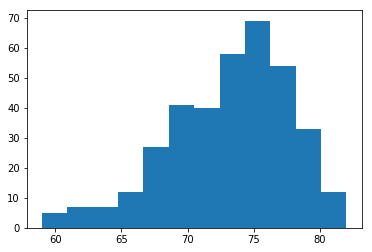

In [22]:
plt.hist(df['tobs'],12)
plt.show()


In [23]:
# Temperature Analysis
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")


def calc_temps(start_date,end_date):
    import datetime
    start_dateobject=datetime.datetime.strptime(start_date, '%Y-%m-%d')
    start_newdate_object=datetime.datetime.date(start_dateobject-datetime.timedelta(days=365))
    start_newdate_string=start_newdate_object.strftime('%Y-%m-%d')
    
    end_dateobject=datetime.datetime.strptime(end_date, '%Y-%m-%d')
    end_newdate_object=datetime.datetime.date(end_dateobject-datetime.timedelta(days=365))
    end_newdate_string=end_newdate_object.strftime('%Y-%m-%d')
    
    data_subset=df[(df['date']>=start_newdate_object) & (df['date']<=end_newdate_object)]
    
    #calculate the minimum temperature
    min_temp=df['tobs'].min()
    max_temp=df['tobs'].max()
    avg_temp=df['tobs'].mean()
    
    #TODO: actually make the function do what it's supposed to do lol
    
    return min_temp, max_temp, avg_temp